#  Principal Component Analysis

In [64]:
%matplotlib inline
plt.rcParams["figure.figsize"] = (16,8)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

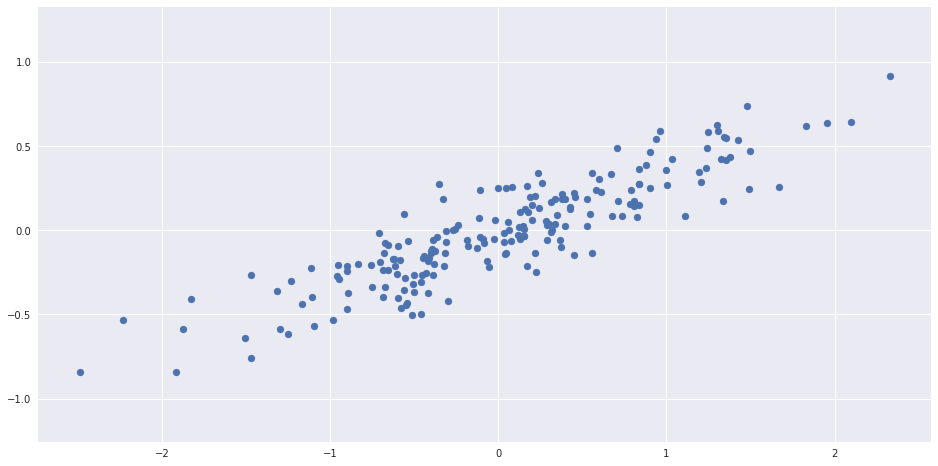

In [65]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal');

In principal component analysis, the relationship between x and y is quantified by finding a list of the *principal axes* in the data, and using those axes to describe the dataset.
Using Scikit-Learn's ``PCA`` estimator, we can compute this as follows:

In [66]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

The fit learns some quantities from the data, most importantly the "components" and "explained variance":

In [67]:
print(pca.components_)

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]


In [68]:
print(pca.explained_variance_)

[ 0.7625315  0.0184779]


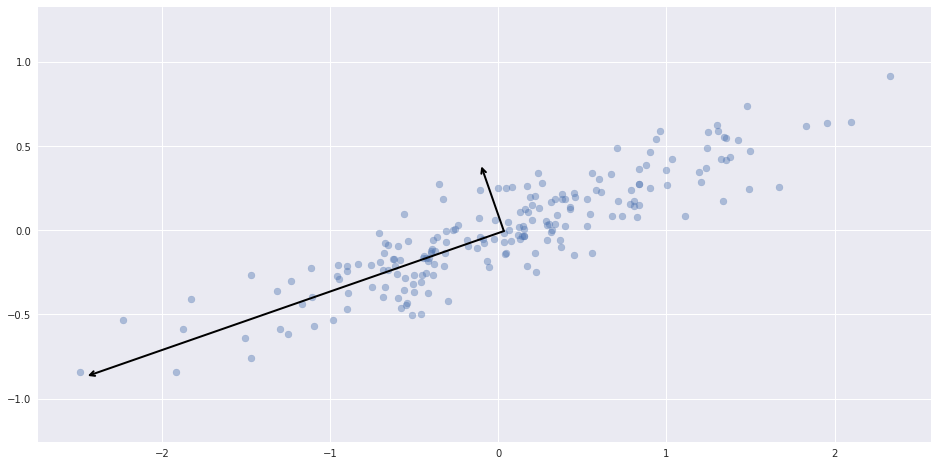

In [69]:
def draw_vector(v0, v1, ax=None):
    ax = ax if ax else plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0)
    ax.annotate('', v1, v0, arrowprops=arrowprops)

    
plt.scatter(X[:, 0], X[:, 1], alpha=0.4)

for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

- The vectors represent the *principal axes* of the data
- The length of the vector is an indication of how "important" that axis is in describing the distribution of the data
    - more precisely, it is a measure of the variance of the data when projected onto that axis.
- The projection of each data point onto the principal axes are the __principal components__ of the data.


[(-3, 3.1),
 Text(0,0.5,'component 2'),
 (-5, 5),
 Text(0.5,0,'component 1'),
 Text(0.5,1,'principal components')]

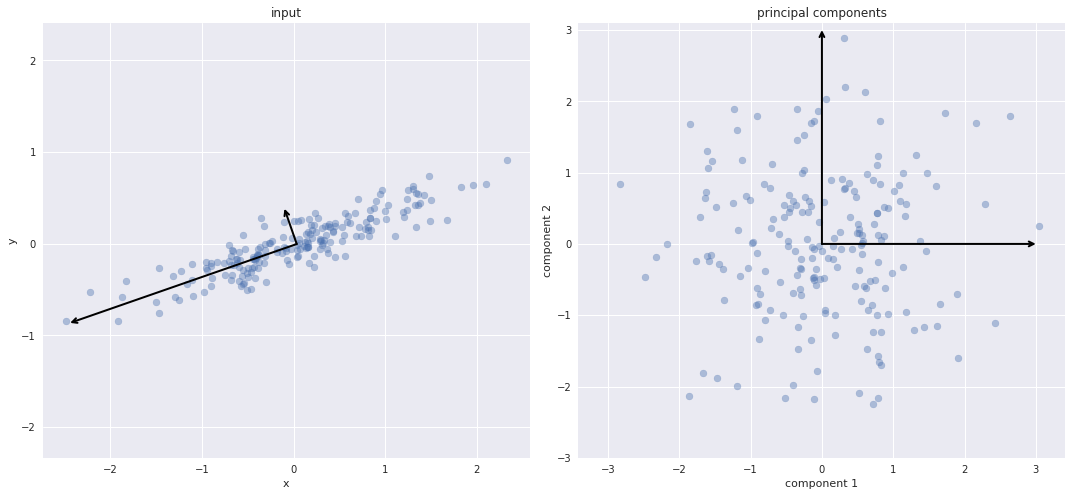

In [70]:
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 200)).T
pca = PCA(n_components=2, whiten=True)
pca.fit(X)

fig, ax = plt.subplots(1, 2)
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

# before rotation
ax[0].scatter(X[:, 0], X[:, 1], alpha=0.4)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v, ax=ax[0])
ax[0].axis('equal');
ax[0].set(xlabel='x', ylabel='y', title='input')

# after rotation
X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.4)
draw_vector([0, 0], [0, 3], ax=ax[1]) # the first vector: starting from at [0,0] ending at [0,3] 
draw_vector([0, 0], [3, 0], ax=ax[1]) # the second vector: starting from at [0,0] ending at [3,0] 
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

This transformation from data axes to principal axes is an **affine transformation**, which basically means it is composed of __a translation, rotation, and uniform scaling__.


Using PCA for dimensionality reduction involves __zeroing out one or more of the smallest principal components__, resulting in a lower-dimensional projection of the data that __preserves the maximal data variance__.


In [71]:
pca = PCA(n_components=1)
pca.fit(X)
X_pca = pca.transform(X)
print("original shape:   ", X.shape)
print("transformed shape:", X_pca.shape)

original shape:    (200, 2)
transformed shape: (200, 1)


The transformed data has been reduced to a single dimension.
To understand the effect of this dimensionality reduction, we can perform the inverse transform of this reduced data:

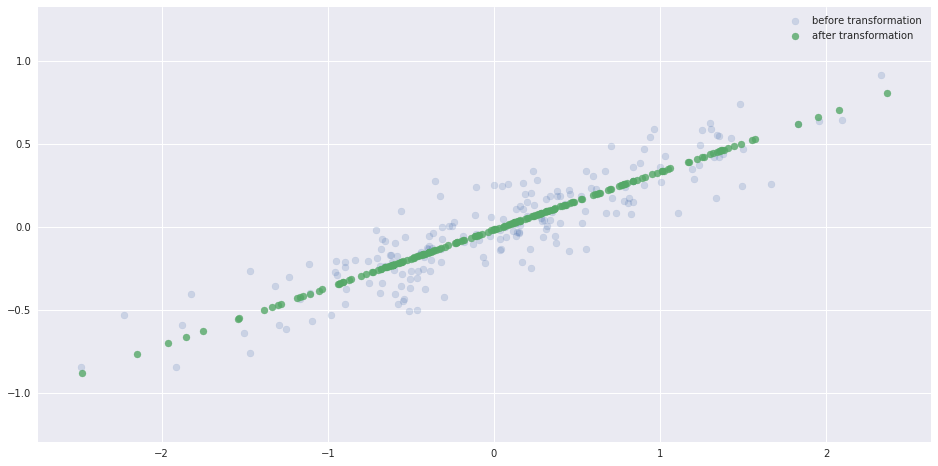

In [72]:
X_new = pca.inverse_transform(X_pca)
plt.scatter(X[:, 0], X[:, 1], alpha=0.2, label="before transformation")
plt.scatter(X_new[:, 0], X_new[:, 1], alpha=0.8, label="after transformation")
plt.axis('equal');
plt.legend(loc='best')

The light points are the original data, while the dark points are the projected version.


This makes clear what a PCA dimensionality reduction means: 

__the information along the least important principal axis or axes is removed, leaving only the component(s) of the data with the highest variance.__

The fraction of variance that is cut out (proportional to the spread of points about the line formed in this figure) is roughly a measure of how much "information" is discarded in this reduction of dimensionality.

This reduced-dimension dataset is in some senses "good enough" to encode the most important relationships between the points: despite reducing the dimension of the data by 50%, the overall relationship between the data points are mostly preserved.

### PCA for visualization: Hand-written digits


In [73]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

In [74]:
pca = PCA(2)  # project from 64 to 2 dimensions
projected = pca.fit_transform(digits.data)
print(digits.data.shape)
print(projected.shape)

(1797, 64)
(1797, 2)


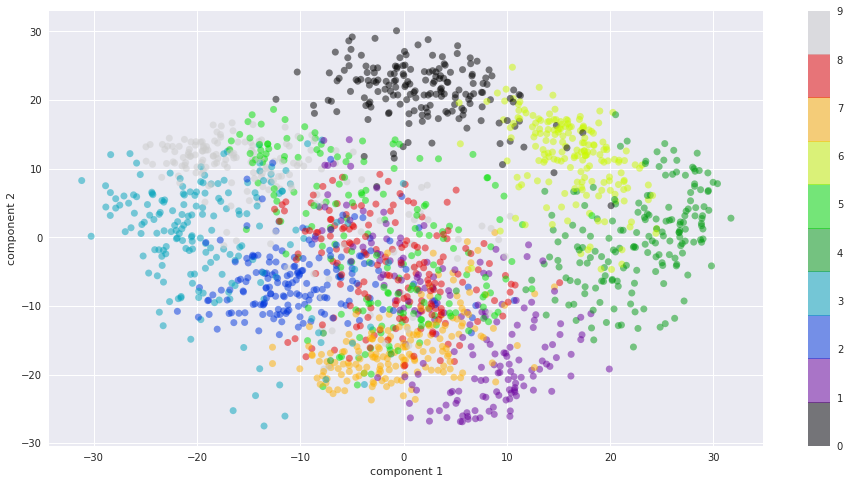

In [76]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=digits.target, edgecolor='none', alpha=0.5,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))

plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar()

the full data is a 64-dimensional point cloud, and these points are the projection of each data point along the directions with the largest variance.


### What do the components mean?


For example, each image in the training set is defined by a collection of 64 pixel values, which we will call the vector x:

$$x = [x_1, x_2, x_3 \cdots x_{64}]$$

One way we can think about this is in terms of a pixel basis.
That is, to construct the image, we multiply each element of the vector by the pixel it describes, and then add the results together to build the image:

$${\rm image}(x) = x_1 \cdot{\rm (pixel~1)} + x_2 \cdot{\rm (pixel~2)} + x_3 \cdot{\rm (pixel~3)} \cdots x_{64} \cdot{\rm (pixel~64)}$$

One way to reduce the dimension of this data is to zero out all but a few of these basis vectors.

- For example, if we use only the first eight pixels, we get an eight-dimensional projection of the data, but it is not very reflective of the whole image since we've thrown out nearly 90% of the pixels.

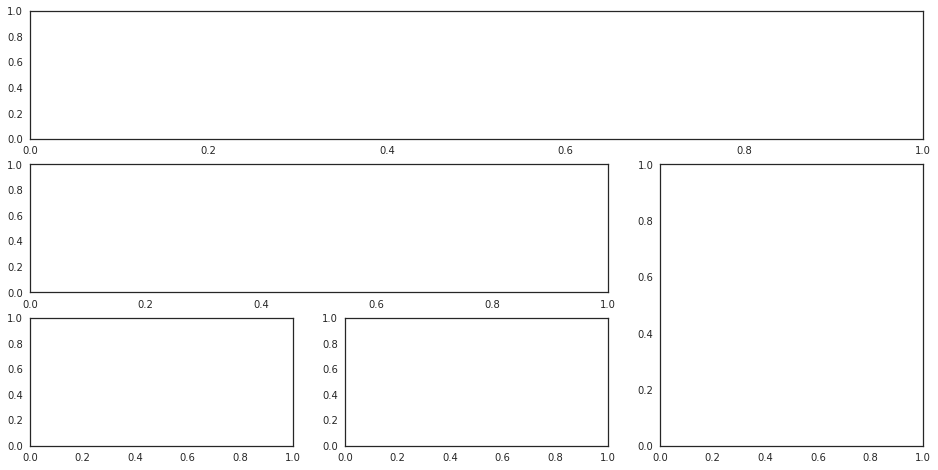

In [113]:
gs = plt.GridSpec(3, 3)
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1, 0])
ax5 = plt.subplot(gs[-1, -2])

In [114]:
slice(2)

slice(None, 2, None)

A GridSpec instance provides array-like (2d or 1d) indexing that returns the SubplotSpec instance. For a SubplotSpec that spans multiple cells, use slice.


In [127]:
def plot_pca_components(x, coefficients=None, mean=0, components=None,
                        imshape=(8, 8), n_components=8, fontsize=12,
                        show_mean=True):
    if coefficients is None:
        coefficients = x
    
    if components is None:
        components = np.eye(len(coefficients), len(x))
        
    mean = np.zeros_like(x) + mean
        
    fig = plt.figure()
    g = plt.GridSpec(2, 4 + bool(show_mean) + n_components, hspace=0.3)

    def show(i, j, x, title=None):
        ax = fig.add_subplot(g[i, j], xticks=[], yticks=[])
        ax.imshow(x.reshape(imshape), interpolation='nearest', cmap="YlGnBu")
        if title:
            ax.set_title(title, fontsize=fontsize)
    show(slice(2), slice(2), x, "True")
    
    approx = mean.copy()
    
    counter = 2
    if show_mean:
        show(0, 2, np.zeros_like(x) + mean, r'$\mu$')
        show(1, 2, approx, r'$1 \cdot \mu$')
        counter += 1

    for i in range(n_components):
        
        approx = approx + coefficients[i] * components[i]
        
        show(0, i + counter, components[i], r'$c_{0}$'.format(i + 1))
        show(1, i + counter, approx,
             r'${0:.2f} \cdot c_{1}$'.format(coefficients[i], i + 1))
        
    show(slice(2), slice(-2, None), approx, "Approx")
    return fig

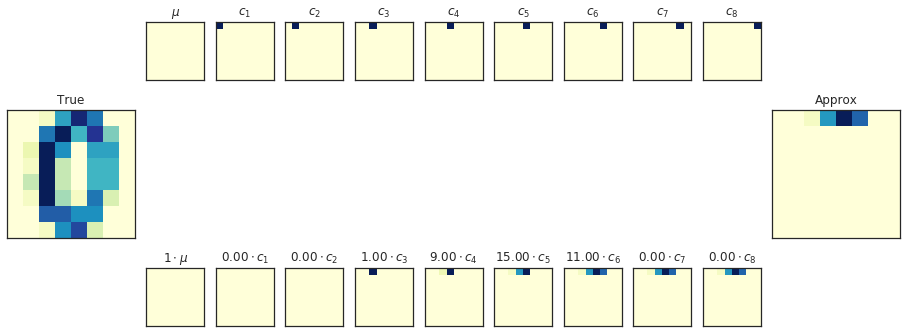

In [128]:
from sklearn.datasets import load_digits

digits = load_digits()
sns.set_style('white')

fig = plot_pca_components(digits.data[10])

The upper row of panels shows the individual pixels, and the lower row shows the cumulative contribution of these pixels to the construction of the image.
Using 10 of the pixel-basis components, we can only construct a small portion of the 64-pixel image.
Were we to continue this sequence and use all 64 pixels, we would recover the original image.

But the pixel-wise representation (_components = np.eye(len(coefficients), len(x))_) is not the only choice of basis. 

We can also use other basis functions:

$$image(x) = {\rm mean} + x_1 \cdot{\rm (basis~1)} + x_2 \cdot{\rm (basis~2)} + x_3 \cdot{\rm (basis~3)} \cdots$$

__PCA can be thought of as a process of choosing optimal basis functions, such that adding together just the first few of them is enough to suitably reconstruct the bulk of the elements in the dataset.
The principal components, which act as the low-dimensional representation of our data, are simply the coefficients that multiply each of the elements in this series.__



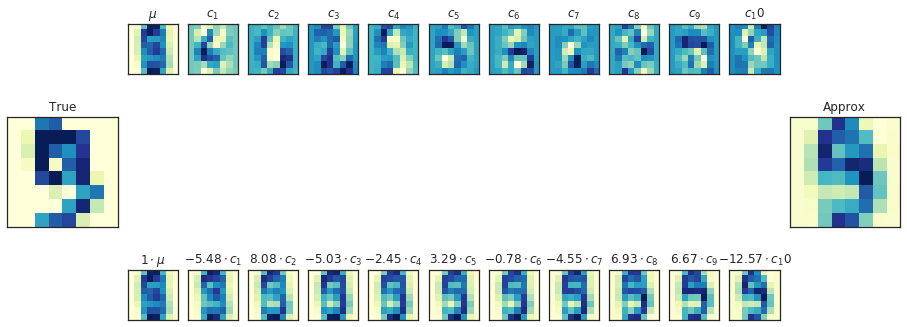

In [129]:
pca = PCA(n_components=10)
Xproj = pca.fit_transform(digits.data)
fig = plot_pca_components(digits.data[9], Xproj[9],
                          pca.mean_, pca.components_, n_components=10)

Unlike the pixel basis, we can recover the features of the input image with just a mean plus 10 components. (_approx=mean.copy(); approx = approx + coefficients[i] * components[i]_)


This is the sense in which PCA provides a low-dimensional representation of the data: it discovers a set of basis functions that are more efficient than the native pixel-basis of the input data.

### Choosing the number of components

A vital part of using PCA in practice is the __ability to estimate how many components are needed to describe the data.__

This can be determined by __looking at the cumulative *explained variance ratio* as a function of the number of components:__

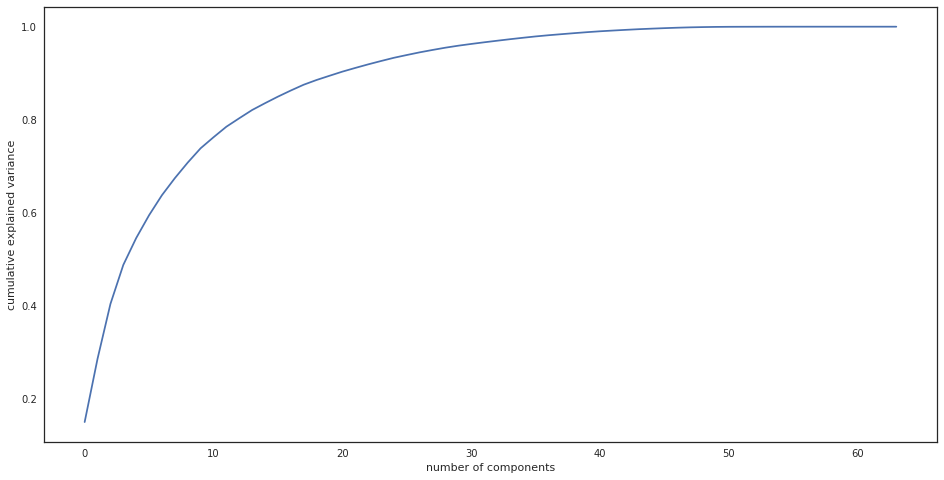

In [122]:
pca = PCA().fit(digits.data)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

This curve quantifies __how much of the total, 64-dimensional variance is contained within the first N components.__

For example, we see that with the digits the first 10 components contain approximately 75% of the variance, while you need around __50 components__ to describe close to 100% of the variance.

Here we can see that our two-dimensional projection loses a lot of information (as measured by the explained variance) and that we'd need about 20 components to retain 90% of the variance.  


Looking at this plot for a high-dimensional dataset can help you understand the level of redundancy present in multiple observations.

## PCA as Noise Filtering

__PCA can also be used as a filtering approach for noisy data.__

The idea is this: any components with variance much larger than the effect of the noise should be relatively unaffected by the noise.


So if you reconstruct the data using just the largest subset of principal components, you should be preferentially keeping the signal and throwing out the noise.


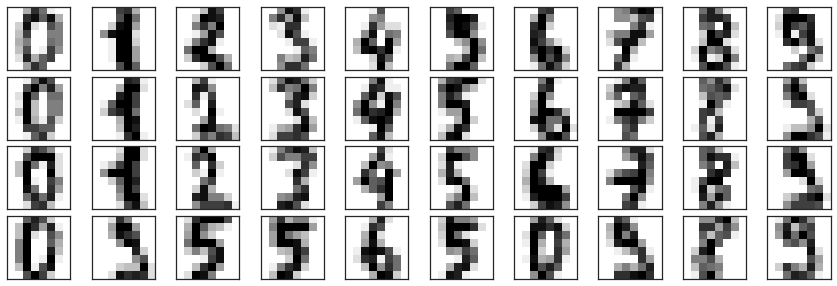

In [171]:
def plot_digits(data):
    fig, axes = plt.subplots(4, 10, figsize=(15, 5),
                             subplot_kw={'xticks':[], 'yticks':[]},
                             gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, ax in enumerate(axes.flat):
        ax.imshow(data[i].reshape(8, 8),
                  cmap='binary', interpolation='nearest',
                  clim=(0, 16))
plot_digits(digits.data)

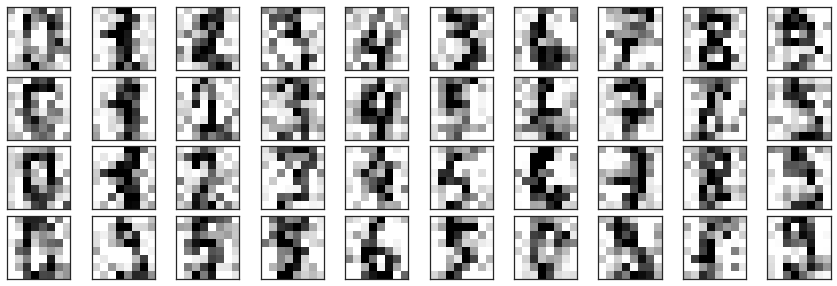

In [172]:
np.random.seed(1)
noisy = np.random.normal(digits.data, 4)
plot_digits(noisy)

In [173]:
pca = PCA(0.5).fit(noisy)
pca.n_components_

12

__Here 50% of the variance amounts to 12 principal components.__

Now we compute these components, and then use the inverse of the transform to reconstruct the filtered digits:

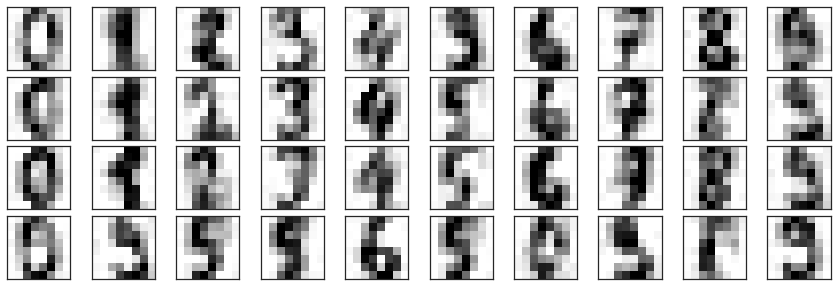

In [174]:
components = pca.transform(noisy)
filtered = pca.inverse_transform(components) # in this process,it gets rid of the vecs that explains less than 0.5 of the variance
plot_digits(filtered)

## Example: Face Feature Extracting


In [175]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)

Since this is a large dataset, we will use ``PCA(svd_solver='randomized')``

> RandomizedPCA contains a randomized method to approximate the first N principal components much more quickly than the standard PCA estimator, and thus is very useful for high-dimensional data (here, a dimensionality of nearly 3,000)

In [176]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100, svd_solver='randomized')
pca.fit(faces.data)

PCA(copy=True, iterated_power='auto', n_components=100, random_state=None,
  svd_solver='randomized', tol=0.0, whiten=False)

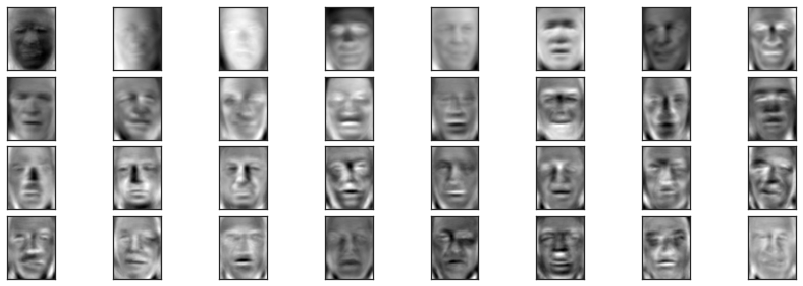

In [177]:
fig, axes = plt.subplots(4, 8, figsize=(15, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='binary_r')

The results actually give us insight into how the images vary: 

- for example, 
    - the first few eigenfaces (from the top left) seem to be associated with the __angle of lighting on the face__
    - and later principal vectors seem to be picking out certain features, __such as eyes, noses, and lips__.


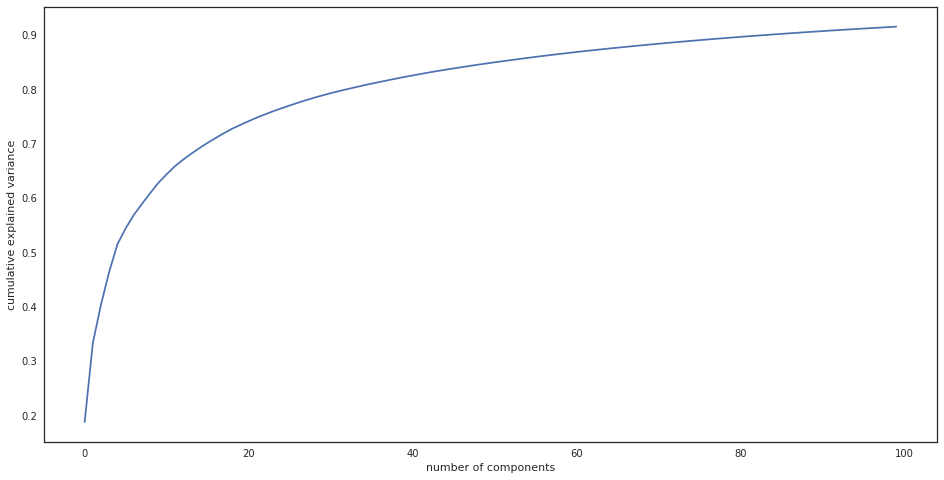

In [148]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [150]:
pca = PCA(n_components=150, svd_solver='randomized').fit(faces.data)
components = pca.transform(faces.data)
projected = pca.inverse_transform(components)

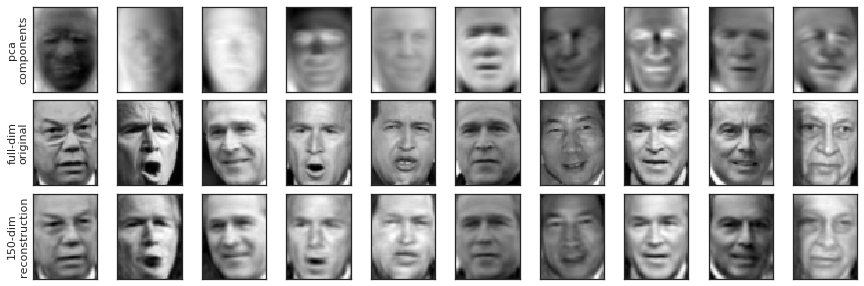

In [169]:
# Plot the results
fig, ax = plt.subplots(3, 10, figsize=(15, 5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(pca.components_[i].reshape(62,47), cmap='binary_r')
    ax[1, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[2, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')

ax[0, 0].set_ylabel('pca\ncomponents')
ax[1, 0].set_ylabel('full-dim\noriginal')
ax[2, 0].set_ylabel('150-dim\nreconstruction');

What this means is that our classification algorithm needs to be trained on 150-dimensional data rather than 3,000-dimensional data, which depending on the particular algorithm we choose, can lead to a much more efficient classification.

## Principal Component Analysis Cons

PCA's main weakness is that it tends to be __highly affected by outliers__ in the data.
For this reason, many robust variants of PCA have been developed, many of which act to iteratively discard data points that are poorly described by the initial components.